# MBA Neutralization using Pattern recognition

Obfuscated MBA expressions often follow specific patterns, although many of us can exploit them. <br> 
In order to recognize them we can use several method like parsing, but also the use of syntactic trees and many others like SAT solvers. <br> 
We have seen that MBAs are composed of operations and variables, these variables can be very simple but also very complex and actually represent a bunch of microcode instructions. 

We can use our generated MBA dataset so we can recognize a lot of patterns !!

## Hex-Rays Microcode API

A great introduction to the decompiler is the [presentation](https://recon.cx/2018/brussels/resources/slides/RECON-BRX-2018-Decompiler-internals-microcode.pdf) that Ilfak Guilfanov gave at RECON where he explains the architecture of Hex-Rays decompiler. <br> The main point of interest for us is its intermediate language, called microcode. At the start of the decompilation, the microcode is simple and looks like RISC code. <br>
Then, multiple optimization passes are executed, which will make the look of the microcode change. For instance, let’s consider the following function:

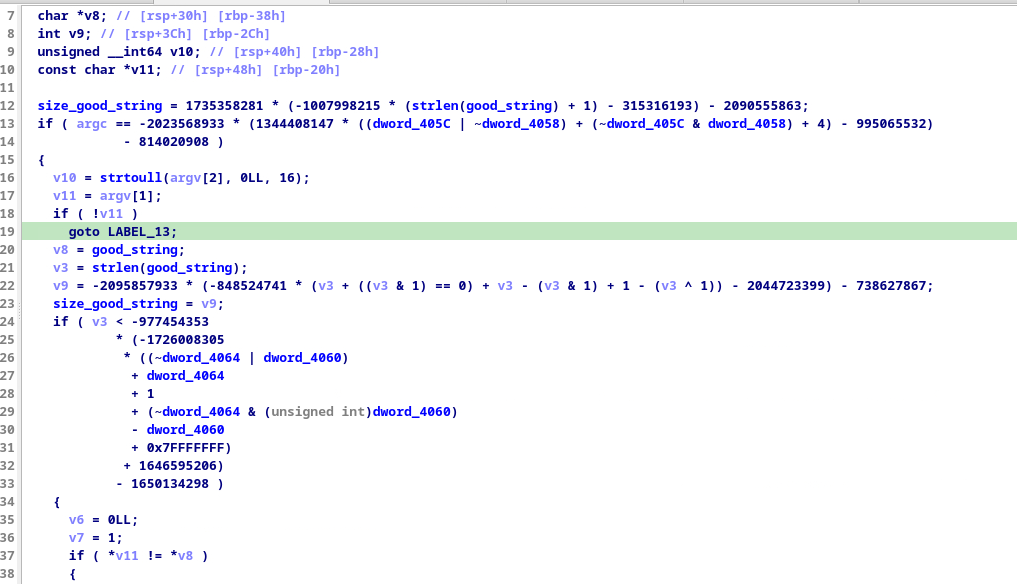

At first, the microcode is very close to assembly language:

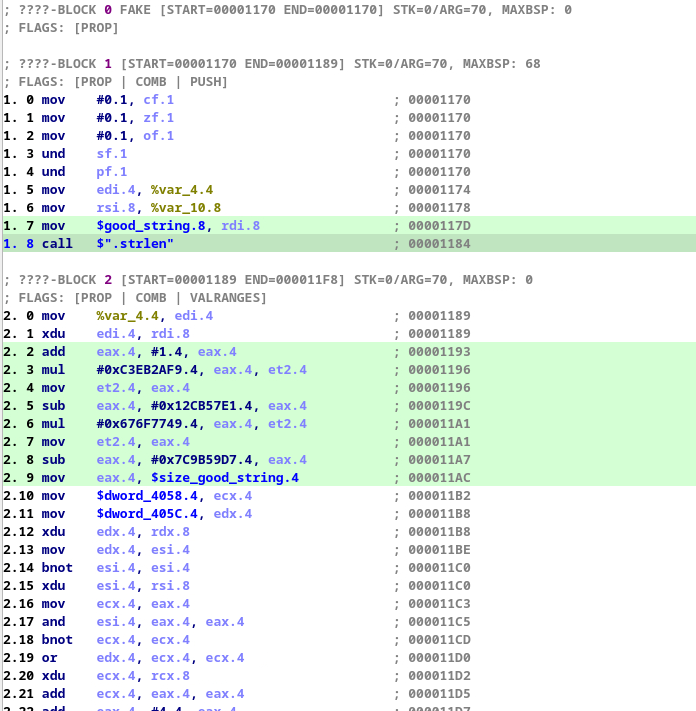

Then, the microcode changes and instructions become more complex:

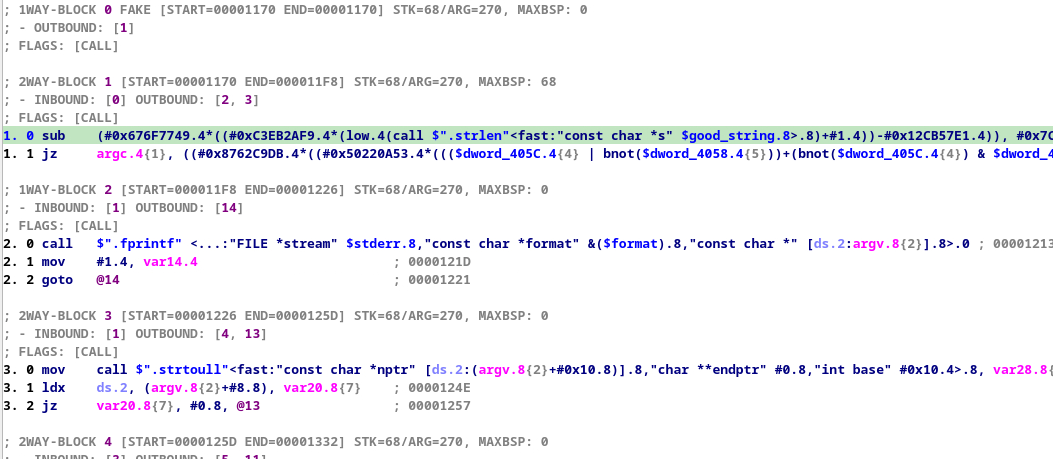

As you can see, in the later "stages", each microcode is composed of multiple nested operations and thus they can be easily represented as a graph like we said in the introduction by Abstract Syntax Tree. For example, here is the graph associated to the `sub` microcode instruction at line 1.0:
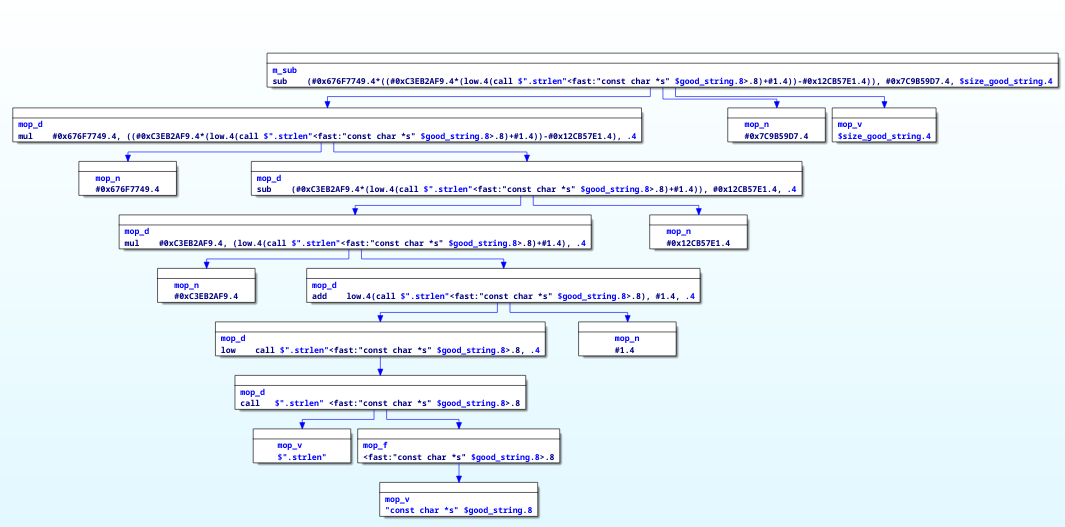

When Hex-Rays released the microcode API, they allowed us to hook the decompilation process in order to modify the microcode at various "stages" named `maturity` of the decompilation.

### Lets go deeper into microcode

The microcode, also called IR (Intermediate Representation), is the first stage of IDA decompilation process. <br>
In this case, microcode is the IR of assembly instruction, think of them like LLVM'S IR.

## Implementation

Each microcode instruction is implemented as a microinstrction from `minsn_t` class and its operands as micro-operands from `mop-t` class. <br><br>

A microinstruction contains 3 operands: 
* `l` for left ;
* `r` for right ;
* `d` for destination...

### Microcode Structure Overview

| **Component**                 | **Object**       | **Description**                                                                                           |
|-------------------------------|------------------|-----------------------------------------------------------------------------------------------------------|
| **Microinstruction**          | `minsn_t`        | Defines the effect of a microinstruction, based on its `opcode` (an instance of `mcode_t`). Can include various operands. Nested instructions possible. Example: `add eax.4, #8.4, ecx.4`. |
| **Operand**                   | `mop_t`          | Holds information depending on the type (e.g., number, register, stack variable, or nested microinstruction). Operands define the data used in microinstructions. |
| **Microcode Basic Block**     | `mblock_t`       | A double-linked list of microinstructions. Represents sequential code execution at the block level. |
| **Function Microcode Object**  | `mbl_array_t`    | A double-linked list of microblocks. Commonly referred to as `mba`, it represents the microcode of an entire function and contains additional info like local variables (`mba->vars`). |
| **Location Lists**            | `mlist_t`        | Used to store lists of locations. These lists are heavily used to represent **Use-Def lists**, tracking where variables are defined and used. |


### Example of a Microinstruction

| **Instruction**       | **Description**                                                                                           |
|-----------------------|-----------------------------------------------------------------------------------------------------------|
| `add eax.4, #8.4, ecx.4` | Adds the constant `8` (with size `.4` bytes) to the `EAX` register, storing the result in the `ECX` register (also `.4` bytes). |

### Microcode Block Structure

| **Component**         | **Description**                                                                                           |
|-----------------------|-----------------------------------------------------------------------------------------------------------|
| **Microcode Basic Block** (`mblock_t`) | A linked list of microinstructions (`minsn_t`) forming a basic block of microcode. |
| **Function Microcode Object** (`mbl_array_t`) | A list of microblocks (`mblock_t`), forming the microcode for an entire function. Commonly called `mba`. Stores extra information, such as local variables (`mba->vars`). |

### Operand (`mop_t`) Types

| **Type**                           | **Description**                                                                                            |
|------------------------------------|------------------------------------------------------------------------------------------------------------|
| **Number**                         | Represents an immediate value (e.g., a constant like `#8.4`).                                              |
| **Register**                       | Represents a CPU register (e.g., `eax.4`).                                                                 |
| **Stack Variable**                 | Represents a variable stored in the stack.                                                                 |
| **Nested Instruction** (`minsn_t`) | A microinstruction that can be nested inside another, adding complexity to the operand.                    |

## Different maturity levels

There are 8 different maturity levels (from the lowest to the highest):
* **MMAT_GENERATED**: immediately after generation
* **MMAT_PREOPTIMIZED**: a pre-optimization stage where the basic structure is established
* **MMAT_LOCOPT**: after local optimizations
* **MMAT_CALLS**: after analysis of function calls
* **MMAT_GLBOPT1**: first stage of global optimizations, improving performance across functions
* **MMAT_GLBOPT2**: second stage of optimizations, refining what was achieved in the previous level
* **MMAT_GLBOPT3**: final stage, involve aggressive optimizations like whole-program analysis, link-time optimization, or deep control/data flow analysis
* **MMAT_LVARS**: optimization/analysis stage of local variables performing stack allocation optimizations and renaming to prevent variable clashes

## MMAT_GENERATED

First one is generated from the assembly listing, the syntax is pretty similar to assembly language. 
There are `mov` (operands reversed), `push/pop` for stack operations, `und` for unimplemented instructions, `call` and so long... All in all there are **72 microinstructions** (to confirm). 

The syntax for the operands is a bit different, a suffix corresponding to the size (in bytes) of the operand is added (ex: eax.4, #0xC5E2B1C.4).

Assembly blocks are split when a call instruction is met -> Microcode basic blocks != assembly basic blocks.

A Use-Def pass is also applied on the assembly, per-instruction and per-block.

Example: here is the first block of a function using some obfuscations techniques.

```
1. 0 mov    esp.4, ebp.4            ; 10018361 u=esp.4      d=ebp.4
1. 1 mov    #0.1, cf.1              ; 10018371 u=           d=cf.1
1. 2 mov    #0.1, zf.1              ; 10018371 u=           d=zf.1
1. 3 mov    #0.1, of.1              ; 10018371 u=           d=of.1
1. 4 und    sf.1                    ; 10018371 u=           d=sf.1
1. 5 und    pf.1                    ; 10018371 u=           d=pf.1
1. 6 mov    #0.1, cf.1              ; 1001837C u=           d=cf.1
1. 7 mov    #0.1, of.1              ; 1001837C u=           d=of.1
1. 8 und    zf.1                    ; 1001837C u=           d=zf.1
1. 9 und    sf.1                    ; 1001837C u=           d=sf.1
1.10 und    pf.1                    ; 1001837C u=           d=pf.1
1.11 mov    ecx.4, esi.4            ; 1001838E u=ecx.4      d=esi.4
1.12 nop                            ; 10018390 u=
1.13 push   esi.4                   ; 10018390 u=esp.4,esi.4 d=esp.4,sp+C.4
1.14 mov    #0x41B21DBA.4, et1.4    ; 10018391 u=           d=et1.4
1.15 mov    et1.4, esi.4            ; 10018391 u=et1.4      d=esi.4
1.16 mov    #0x15CF5AD2.4, et1.4    ; 10018396 u=           d=et1.4
1.17 mov    et1.4, esi.4            ; 10018396 u=et1.4      d=esi.4
1.18 mov    #0x2E960483.4, et1.4    ; 1001839B u=           d=et1.4
1.19 mov    et1.4, esi.4            ; 1001839B u=et1.4      d=esi.4
1.20 mov    #0x1CBD43F8.4, et1.4    ; 100183A0 u=           d=et1.4
1.21 mov    et1.4, esi.4            ; 100183A0 u=et1.4      d=esi.4
1.22 nop                            ; 100183A5 u=
1.23 pop    esi.4                   ; 100183A5 u=esp.4,sp+C.4 d=esp.4,esi.4
1.24 mov    #0x100183AB.4, ett.4    ; 100183A6 u=           d=ett.4
1.25 nop                            ; 100183A6 u=
1.26 nop                            ; 100183A6 u=
1.27 mov    cs.2, seg.2             ; 100183A6 u=cs.2       d=seg.2
1.28 mov    #0x102287B2.4, eoff.4   ; 100183A6 u=           d=eoff.4
1.29 call   $_rand                  ; 100183A6 u=(rax.8,rcx.8,ebp.4,rdi.8,st0.8,st1.8...)
```

## MMAT_PREOPTIMIZED

Use-Def information is used to:
* delete dead code (if the instruction result is not used, the instruction is deleted)
* propagate operands and instructions across blocks boundaries
* generate assertions for future optimizations -> add new microinstructions to represent assertions (`assert` in comment)

Example: same block as before.

```
1. 0 mov    esp.4, ebp.4            ; 10018361 u=esp.4      d=ebp.4
1. 1 mov    #0.1, cf.1              ; 1001837C u=           d=cf.1
1. 2 mov    #0.1, of.1              ; 1001837C u=           d=of.1
1. 3 und    zf.1                    ; 1001837C u=           d=zf.1
1. 4 und    sf.1                    ; 1001837C u=           d=sf.1
1. 5 und    pf.1                    ; 1001837C u=           d=pf.1
1. 6 mov    ecx.4, esi.4            ; 1001838E u=ecx.4      d=esi.4
1. 7 call   $_rand                  ; 100183A6 u=(rax.8,rcx.8,ebp.4,rdi.8,st0.8,st1.8...)
```

2nd example: second block

```
2. 0 ldx    ds.2, (esi.4+#0x24.4), eax.4 ; 100184B3 u=esi.4,ds.2,(GLBLOW,LVARS,ARGS,GLBHIGH) d=eax.4
2. 1 add    eax.4, #0xF.4, eax.4    ; 100184B6 u=eax.4      d=eax.4
2. 2 mul    #3.4, eax.4, ecx.4      ; 100184B9 u=eax.4      d=ecx.4
2. 3 mov    #0x2AAAAAAB.4, eax.4    ; 100184BC u=           d=eax.4
2. 4 mul    #2.4, ecx.4, ecx.4      ; 100184C1 u=ecx.4      d=ecx.4
2. 5 mul    xds.8(ecx.4), xds.8(eax.4), rt2.8 ; 100184C3 u=eax.4,ecx.4 d=rt2.8
2. 6 mov    rt2^4.4, edx.4          ; 100184C3 u=rt2^4.4    d=edx.4
2. 7 ldx    ds.2, (esi.4+#0x24.4), eax.4 ; 100184C5 u=esi.4,ds.2,(GLBLOW,LVARS,ARGS,GLBHIGH) d=eax.4
2. 8 mov    edx.4, ecx.4            ; 100184C8 u=edx.4      d=ecx.4
2. 9 shr    ecx.4, #0x1F.1, ecx.4   ; 100184CA u=ecx.4      d=ecx.4
2.10 add    edx.4, ecx.4, ecx.4     ; 100184CD u=edx.4,ecx.4 d=ecx.4
2.11 sub    ecx.4, eax.4, ecx.4     ; 100184CF u=eax.4,ecx.4 d=ecx.4
2.12 setb   ecx.4, #0xF.4, cf.1     ; 100184D1 u=ecx.4      d=cf.1
2.13 seto   ecx.4, #0xF.4, of.1     ; 100184D1 u=ecx.4      d=of.1
2.14 setz   ecx.4, #0xF.4, zf.1     ; 100184D1 u=ecx.4      d=zf.1
2.15 setp   ecx.4, #0xF.4, pf.1     ; 100184D1 u=ecx.4      d=pf.1
2.16 sets   (ecx.4-#0xF.4), sf.1    ; 100184D1 u=ecx.4      d=sf.1
2.17 jcnd   ((sf.1 ^ of.1) | zf.1), $loc_100187A8 ; 100184D4 u=zf.1,sf.1,of.1
```

## MMAT_LOCOPT

Propagation pass again with the new Use-Def listing. Define local variables names for stack pointer offsets.

Example: 2nd example from before (1st one is unchanged)

```
2. 0 high   (#0x2AAAAAAB.8*xds.8((#6.4*([ds.2:(esi.4+#0x24.4)].4+#0xF.4)))), edx.4 ; 100184C3 u=esi.4,ds.2,(GLBLOW,LVARS,ARGS,GLBHIGH) d=edx.4
2. 1 ldx    ds.2, (esi.4+#0x24.4), eax.4 ; 100184C5 u=esi.4,ds.2,(GLBLOW,LVARS,ARGS,GLBHIGH) d=eax.4
2. 2 sub    ((#6.4*([ds.2:(esi.4+#0x24.4)].4+#0xF.4)) /s #6.4), eax.4, ecx.4 ; 100184CF u=eax.4,esi.4,ds.2,(GLBLOW,LVARS,ARGS,GLBHIGH) d=ecx.4
2. 3 setb   ecx.4, #0xF.4, cf.1     ; 100184D1 u=ecx.4      d=cf.1
2. 4 seto   ecx.4, #0xF.4, of.1     ; 100184D1 u=ecx.4      d=of.1
2. 5 setz   ecx.4, #0xF.4, zf.1     ; 100184D1 u=ecx.4      d=zf.1
2. 6 setp   ecx.4, #0xF.4, pf.1     ; 100184D1 u=ecx.4      d=pf.1
2. 7 sets   (ecx.4-#0xF.4), sf.1    ; 100184D1 u=ecx.4      d=sf.1
2. 8 jle    ecx.4, #0xF.4, @6       ; 100184D4 u=ecx.4
```

It propagates all the instructions from 0 to 6 in 1 instruction, and same for 8 to 11.

## MMAT_CALLS

Propagations pass again + ABI is retrieved for calls so arguments can be identified and new assertions can be made. 

Example: first block

```
1. 0 mov    &(%" s").4, ebp.4       ; 10018361 u=           d=ebp.4
1. 1 mov    ecx.4{1}, esi.4{1}      ; 1001838E u=ecx.4      d=esi.4
1. 2 call   $_rand <cdecl:>.0       ; 100183A6 u=(GLBLOW,sp+2E8..,GLBHIGH) d=(cf.1,zf.1...)
```

Example: second block

```
jle    (((#6.4*([ds.2{3}:(esi.4{1}+#0x24.4){4}].4{2}+#0xF.4)) /s #6.4)-[ds.2{3}:(esi.4{1}+#0x24.4){4}].4{2}), #0xF.4, @6 
```

Instruction at 0 was removed because not used anywhere, 1 and 2 have been propagated into 8 instruction. Flags are not used so they were removed as well.

## MMAT_GLBOPT1

Blocks are merged (if split because of calls) and function prologue/epilogue are removed.

Example: 2 first blocks

```
1. 0 mov    ecx.4{1}, esi.4{1}      ; 1001838E u=ecx.4      d=esi.4
1. 1 call   $_rand <cdecl:>.0       ; 100183A6 u=(GLBLOW,GLBHIGH) d=(cf.1,zf.1...)
1. 2 jle    (((#6.4*([ds.2{3}:(esi.4{1}+#0x24.4){4}].4{2}+#0xF.4)) /s #6.4)-[ds.2{3}:(esi.4{1}+#0x24.4){4}].4{2}), #0xF.4, @3
```

## MMAT_GLBOPT2

No differences observed.

## MMAT_GLBOPT3

No differences observed.

## MMAT_LVARS

SSA pass is applied and registers considered as local variables.

Example: 2 first blocks

```
1. 0 mov    this.4{1}, esi1.4{1}    ; 1001838E u=ecx.4      d=esi.4
1. 1 call   $_rand <cdecl:>.0       ; 100183A6 u=(GLBLOW,GLBHIGH) d=(cf.1,zf.1...)
1. 2 jle    (((#6.4*([ds.2{3}:(esi1.4{1}+#0x24.4){4}].4{2}+#0xF.4)) /s #6.4)-[ds.2{3}:(esi1.4{1}+#0x24.4){4}].4{2}), #0xF.4, @3
```

SSA can be observed with suffix number on registers (they will be later renamed with variables names, ECX is renamed to `this` for C++).



## Binary Ninja

